### Scattering of a plane wave by a homogeneous sphere with density contrast

This demo illustrates how to:

 * Compute the scattering of a plane wave by a homogeneous dielectric obstable
 * Solve the volume integral equation using an iterative method
 * Postprocess the solution to evaluate the total field
 * Check the accuracy by comparing to the analytical solution
 * Make a nice plot of the solution in the domain

In [1]:
import os
import sys
# FIXME: figure out how to avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from vines.geometry.geometry import shape
from vines.fields.plane_wave import PlaneWave
from vines.operators.acoustic_operators import volume_potential
from vines.precondition.threeD import circulant_embed_fftw, circulant_gradient_embed
from vines.operators.acoustic_matvecs import mvp_vec_fftw, mvp_domain, mvp_potential_x_perm, mvp_vec_rho_fftw, mvp_potential_grad
from scipy.sparse.linalg import LinearOperator, gmres, bicgstab
from analytical.mie_series_function import mie_function, mie_function_density_contrast
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D 
from plotting import set_axes_equal
import time

In this example, we consider the scattering of a plane wave by a homogeneous sphere with a differing wavespeed *and* density to the background medium. The consideration of a density contrast leads to an extra operator arising in the volume integral equation (VIE) formulation. For low density contrasts, it is reasonable to ignore this term, however for larger contrasts the accuracy becomes poor. We begin by briefly presenting the Helmholtz scattering problem and reformulation as a VIE, following the exposition of [1].

[1] Costabel, Martin. "On the spectrum of volume integral operators in acoustic scattering." Integral Methods in Science and Engineering. Birkhäuser, Cham, 2015. 119-127

The Helmholtz equation under consideration is the following:
$$
    \nabla\cdot\left(\frac{1}{\rho(x)}\nabla u\right) + \frac{k^2(x)}{\rho(x)}u(x) = 0,
$$
where the wavenumber $k$ and density $\rho$ are spatially varying. Suppose that the denisty and wavenumber of the background medium are $\rho_0$ and $k_0$, respectively. Introduce the following contrast functions:
$$
    \alpha(x) := \frac{1}{\rho(x)} - \frac{1}{\rho_0};\quad \beta(x) := \frac{k^2(x)}{\rho(x)} - \frac{k_0^2}{\rho_0}.
$$

The Helmhtolz equation can be reformulated as the volume integral equation:
$$
    u - \rho_0\int_{\Omega}G(x,y)\beta(y)u(y)\text{d}y - \rho_0\nabla\cdot\int_{\Omega}G(x,y)\alpha(y)\nabla u(y)\text{d}y = u^{\text{inc}}
$$
We note that if $\rho \equiv\rho_0$, then this reduces to the following:
$$
    u - \int_{\Omega}G(x,y)(k^2(y) - k_0^2)u(y)\text{d}y = u^{\text{inc}}.
$$
We anticipate that this equation is accurate also for small contrast, i.e., when $\rho\approx\rho_0$.

For stronger density contrasts, it is likely that we cannot so readily discard the divergence term. The full form above, however, is not well suited to be solved since we have two unknowns: $u$ and $\nabla u$. Therefore, we perform integration by parts on the final term on the left-hand side. If the density function $\rho$ is **smooth** everywhere, then we arrive at
$$
    \frac{\rho_0}{\rho(x)}u(x) - \rho_0k_0^2\int_{\Omega}G(x, y)\frac{(\mu(y)^2-1)}{\rho(y)}u(y)\text{d}y + \rho_0\nabla\cdot \int_{\Omega}G(x,y)(\nabla\alpha)(y)u(y)\text{d}y = u^{\text{inc}}(x),
$$
where we have chosen to write $k(x)=\mu(x)k_0$, with $\mu$ the refractive index.

If instead, the density contrast is piecewise smooth (as is more realistic), then a boundary integral term arises from the integration by parts. The resulting VIE is:
$$
    \frac{\rho_0}{\rho(x)}u(x) - \rho_0k_0^2\int_{\Omega}G(x, y)\frac{(\mu(y)^2-1)}{\rho(y)}u(y)\text{d}y + \rho_0\nabla\cdot \int_{\Omega}G(x,y)(\nabla\alpha)(y)u(y)\text{d}y + \int_{\Gamma}\partial_nG(x,y)\alpha(y)u(y)\text{d}s(y) = u^{\text{inc}}(x).
$$
That is, we have an additional double layer operator.

In this notebook we shall just use the simplest equation, derived from assuming that $\rho\equiv\rho_0$. By experimentation with different contrasts, we can deduce what a sufficiently *low density contrast* means for our desired accuracy. Implementing the additional operators required for a strong density contrast would require some careful thought and some, and potentially a coupling to a boundary element solver such as BEMpp.


In [2]:
'''                         Define parameters                               '''
# We consider a sphere of radius 1mm and refractive index 1.2
# The incident field is a plane wave of wavelength 0.5mm and unit amplitude
# travelling in the positive x-direction
# Sphere info
geom = 'sphere'
radius = 2.5e-3
refInd = 1.2 + 1j * 0.0
# Densities
rho0 = 1.0e3
rho1 = 1.06e3
# Wavelength
lambda_ext = 1.5e-3
# Plane wave info
Ao = 1
direction = np.array((1, 0, 0))
ko = 2 * np.pi / lambda_ext  # exterior wavenumber

print('Size parameter = ', ko * radius)

Size parameter =  10.471975511965978


In [3]:
# Define the resolution of the voxel mesh - this is given in terms of number
# of voxels per wavelength. 10 voxels per wavelength typically gives a
# reasonable (<5%) accuracy. See demo_convergence.py for an example script in
# which the convergence of the scheme is considered w.r.t. mesh resolution
nPerLam = 10

# Get mesh geometry and interior wavelength
r, idx, res, P, lambda_int = shape(geom, refInd, lambda_ext, radius,
                                   nPerLam, 1)

(L, M, N) = r.shape[0:3]  # number of voxels in x-, y-, z-directions

(L, M, N, _) = r.shape  # number of voxels in x-, y-, z-directions
#  Arrays containing the x, y, z coordinates, these are handy for plotting the geometry
xd = r[:, :, :, 0]
yd = r[:, :, :, 1]
zd = r[:, :, :, 2]

# Voxel dimension
dx = r[1, 0, 0, 0] - r[0, 0, 0, 0]

In [4]:
# Get plane wave incident field
Uinc = PlaneWave(Ao, ko, direction, r)

In [5]:
# Voxel permittivities
Mr = np.zeros((L, M, N), dtype=np.complex128)
Mr[idx] = refInd**2 - 1

In [6]:
# Density contrast operators. Not required if using the simplest VIE. I tried a rough implementation of the second VIE presented in the introduction (assuming smooth density), but it's not accurate. This requires more thought.
# Dr = np.zeros((L, M, N))
# Dr[idx] = rho0 / rho1 - 1

# rho_ratio = np.ones((L, M, N), dtype=np.complex128)
# rho_ratio[idx] = rho0 / rho1

# RHO = np.ones((L, M, N), dtype=np.complex128)
# RHO[idx] = rho1
# RHO[np.invert(idx)] = rho0

# # Compute gradient of density contrast
# from findiff import FinDiff, Gradient
# grad = Gradient(spac=[dx, dx, dx])
# Dr_grad = grad(Dr)

# import matplotlib.pyplot as plt
# plt.imshow(Dr_grad[2,:,:,10])
# plt.colorbar()

In [7]:
# Assemble volume potential operator
toep = volume_potential(ko, r)
toep = ko**2 * toep

# Circulant embedding of volume potential operator
circ_op = circulant_embed_fftw(toep, L, M, N)

In [8]:
# This is for 2nd VIE (requires work)
# # Assemble gradient of volume potential operator
# from vines.operators.acoustic_operators import grad_potential
# toep_grad = grad_potential(ko, r)
# # Circulant embedding of gradient of potential operator
# circ_op_grad = circulant_gradient_embed(toep_grad, L, M, N)

In [9]:
# Create array that has the incident field values in sphere, and zero outside sphere
xIn = np.zeros((L, M, N), dtype=np.complex128)
xIn[idx] = Uinc[idx]
# Reshape into vector for linear system
xInVec = xIn.reshape((L*M*N, 1), order='F')

In [10]:
# Set up matvec and linear operator
mvp = lambda x: mvp_vec_fftw(x, circ_op, idx, Mr)

# Matvec for 2nd VIE (requires work)
# mvp = lambda x: mvp_vec_rho_fftw(x, circ_op, circ_op_grad, idx, Mr, Dr_grad,
#                      rho_ratio)

A = LinearOperator((L*M*N, L*M*N), matvec=mvp)

In [11]:
# Iterative solve with GMRES or BiCG-Stab (or iterative solver of your choice)
def residual_vector(rk):
    'Function to store residual vector in iterative solve'
    global resvec
    resvec.append(rk)

start = time.time()
resvec = []
# sol, info = gmres(A, xInVec, tol=1e-5, callback=residual_vector)
sol, info = bicgstab(A, xInVec, tol=1e-5, callback=residual_vector)
print("The linear system was solved in {0} iterations".format(len(resvec)))
end = time.time()
print('Solve time = ', end-start, 's')

The linear system was solved in 16 iterations
Solve time =  0.8914241790771484 s


In [12]:
# Evalute field in domain for 2nd VIE (requires work)
# idx_n = np.ones((L, M, N), dtype=bool)
# Usca = mvp_potential_x_perm(sol, circ_op, idx_n, Mr/RHO).reshape(L, M, N, order='F')
# Vtemp = mvp_potential_grad(sol, circ_op_grad, idx, Dr_grad, rho_ratio).reshape(L, M, N, order='F')
# U  = Uinc - Dr * sol.reshape(L, M, N, order='F') + rho0 * Usca - rho0 * Vtemp

In [13]:
# Compute scattered and hence total field
idx_n = np.ones((L, M, N), dtype=bool)
Usca = mvp_potential_x_perm(sol, circ_op, idx_n, Mr).reshape(L, M, N, order='F')
U = Uinc + Usca

In [14]:
# Get the analytical solution on central slice for comparison
P = mie_function_density_contrast(ko * radius, refInd, L, rho0, rho1)

In [15]:
U_centre = U[:, :, np.int(np.round(N/2))]
error = np.linalg.norm(U_centre-np.conj(P)) / np.linalg.norm(P)
print('Error = ', error)

Error =  0.046795962180051304


Text(0.5, 1.0, 'VIE approx - exact solution')

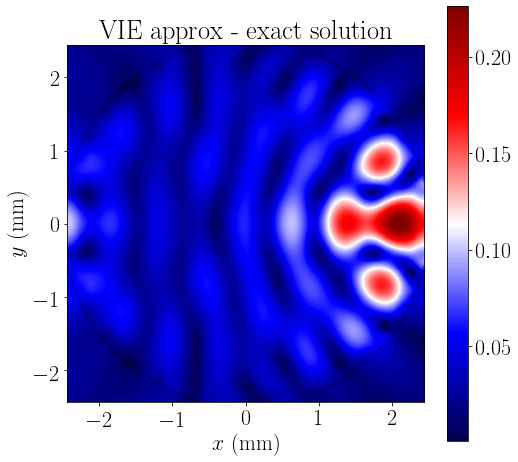

In [21]:
# Create pretty plot of field over central slice of the sphere
matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# Domain extremes
xmin, xmax = r[0, 0, 0, 0], r[-1, 0, 0, 0]
ymin, ymax = r[0, 0, 0, 1], r[0, -1, 0, 1]
plt.imshow(np.abs((U_centre-np.conj(P)).T),
           extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$y$ (mm)')
circle = plt.Circle((0., 0.), radius*1e3, color='black', fill=False,
                    linestyle=':')
ax.add_artist(circle)
plt.colorbar()
plt.title('VIE approx - exact solution')
# fig.savefig('results/sphere.pdf')
# plt.close()